# Projeto 2 - NLP

-----


### Importação de Bibliotecas

In [73]:
# Bibliotecas de manipulação de dados e pré processamento
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from unidecode import unidecode 
from wordcloud import WordCloud
from PIL import Image
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec,doc2vec

# Bibliotecas para métricas de avaliação de modelos
from sklearn.model_selection import train_test_split,KFold,cross_validate,cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score,classification_report
from mlxtend.plotting import plot_confusion_matrix
from mlxtend.evaluate import confusion_matrix

# Bibliotecas com os modelos de classificação
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Biblioteca para otimização de hiperparâmetros
import optuna
from optuna.visualization import plot_contour
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

### Etapa 1) Análise de consistência dos dados e Análise Exploratória

In [2]:
# Carregando os datasets

df_train = pd.read_csv("Train3Classes.csv")
df_subm = pd.read_csv("Subm3Classes.csv")

display(df_train, df_subm)

id                                         tweet_text  \
0      1049721159292346368  Rio elege maior bancada policial de sua histór...   
1      1046251157025423360  fiquei tão triste quando eu vi o preço da câme...   
2      1041744620206653440  Para Theresa May, seu plano para o Brexit é a ...   
3      1046937084727107589  caralho eu quero proteger a danielly em um pot...   
4      1047326854229778432                         @SiCaetano_ viva o caos :)   
...                    ...                                                ...   
94995  1041831666883321856  Cuba e defensor de direitos humanos se unem co...   
94996  1032352892194369536  #Oportunidade ➡️ Venha fazer parte da nossa eq...   
94997  1046785538542440448  @96syoo EU SEI 😭😭 é por isso que significa mui...   
94998  1045457469110177792            @louistsexhes N te conheço mas posta :D   
94999  1046239135286136832                meu deus :( https://t.co/BlXazxZeKq   

                           tweet_date  sentiment     query_used  
0      Tue Oct 09 18:00:01 +0000 2018          2          folha  
1      Sun Sep 30 04:11:28 +0000 2018          0             :(  
2      Mon Sep 17 17:44:06 +0000 2018          2          exame  
3      Tue Oct 02 01:37:06 +0000 2018          0             :(  
4      Wed Oct 03 03:25:55 +0000 2018          1             :)  
...                               ...        ...            ...  
94995  Mon Sep 17 23:30:00 +0000 2018          2   jornaloglobo  
94996  Wed Aug 22 19:44:44 +0000 2018          2  #oportunidade  
94997  Mon Oct 01 15:34:55 +0000 2018          0             :(  
94998  Thu Sep 27 23:37:38 +0000 2018          1             :)  
94999  Sun Sep 30 03:23:42 +0000 2018          0             :(  

[95000 rows x 5 columns]

id                                         tweet_text  \
0     1046764676707753987  Apartamento Vila Mariana Praça Monteiro dos Sa...   
1     1047329264943751169  @FalleNCS @BrasilGameShow quero 1x1 de scout. ...   
2     1045443874947313665  mais uma analógica no correio à minha espera :...   
3     1040484298711814144  Em festa de posse como presidente do STF, Toff...   
4     1045411876887306240  @thethiagor @jubsilva @GSCISA @GrupoMulheRIs A...   
...                   ...                                                ...   
4995  1049243861732794369  Não é nada demais , apenas a verdade :) — Oh.....   
4996  1039334757690163201  Veja o que é #FATO ou #FAKE na entrevista de A...   
4997  1049286902577356801  @nattvieiira de quem???? queria ver, eu sai po...   
4998  1045349300744671232  ASSASSIN'S CREED ORIGINS: ENFRENTANDO OS IRMÃO...   
4999  1046943420210659328  a gnt conversava muito mas paramos :( te acho ...   

                          tweet_date query_used  
0     Mon Oct 01 14:12:01 +0000 2018         :)  
1     Wed Oct 03 03:35:29 +0000 2018         :)  
2     Thu Sep 27 22:43:37 +0000 2018         :)  
3     Fri Sep 14 06:16:02 +0000 2018      folha  
4     Thu Sep 27 20:36:28 +0000 2018         :)  
...                              ...        ...  
4995  Mon Oct 08 10:23:25 +0000 2018         :)  
4996  Tue Sep 11 02:08:10 +0000 2018      #fato  
4997  Mon Oct 08 13:14:27 +0000 2018         :(  
4998  Thu Sep 27 16:27:49 +0000 2018         :)  
4999  Tue Oct 02 02:02:17 +0000 2018         :(  

[5000 rows x 4 columns]

In [3]:
# Dimensão dos dataframes

display(df_train.shape, df_subm.shape)

(95000, 5)

(5000, 4)

Na base de treino temos 95 mil linhas e 5 colunas enquanto que na base de submissão, temos 5 mil linhas e 4 colunas (não existe a coluna sentimento, a qual iremos prever o resultado após o nosso modelo final de NLP).

In [4]:
# Informações sobre o dataset de treino

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95000 entries, 0 to 94999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          95000 non-null  int64 
 1   tweet_text  95000 non-null  object
 2   tweet_date  95000 non-null  object
 3   sentiment   95000 non-null  int64 
 4   query_used  95000 non-null  object
dtypes: int64(2), object(3)
memory usage: 3.6+ MB


In [5]:
# Informações sobre o dataset de submissão

df_subm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          5000 non-null   int64 
 1   tweet_text  5000 non-null   object
 2   tweet_date  5000 non-null   object
 3   query_used  5000 non-null   object
dtypes: int64(1), object(3)
memory usage: 156.4+ KB


Ambos os datasets, treino e submissão, não possuem dados ausentes.

In [6]:
# Criação de filtro para verificar se existem dados duplicados

filtro_duplicado = df_train.duplicated()
filtro_duplicado_subm = df_subm.duplicated()

In [7]:
# Verificando os valores

display(df_train[filtro_duplicado], df_subm[filtro_duplicado_subm])

Empty DataFrame
Columns: [id, tweet_text, tweet_date, sentiment, query_used]
Index: []

Empty DataFrame
Columns: [id, tweet_text, tweet_date, query_used]
Index: []

Não existem dados duplicados.

In [8]:
# Verificando se consta algum valor da base de treino na base de submissão
id_subm_treino = [id_cliente for id_cliente in df_train["id"] if id_cliente in df_subm["id"]]

# Filtrando a partir da lista de ID´s
df_train.loc[id_subm_treino,:]

Empty DataFrame
Columns: [id, tweet_text, tweet_date, sentiment, query_used]
Index: []

Não existe nenhum ID de treino na base de submissão.

Vamos verificar se existem ID´s com mais de um tweet ou se são somente ID´s únicos.

In [9]:
# verificando quantos ID´s únicos existem

display(df_train["id"].nunique(), df_subm["id"].nunique())

94987

5000

Na base de treino, existem 13 ID´s que fizeram mais de um tweet e nenhum na base de submissão.

In [10]:
# Verificação as classes de sentimento, onde O = Negativo, 1 = Positivo, 2 = Neutro

df_train["sentiment"].value_counts()

0    31696
1    31678
2    31626
Name: sentiment, dtype: int64

In [11]:
df_train["sentiment"].value_counts(normalize=True)

0    0.333642
1    0.333453
2    0.332905
Name: sentiment, dtype: float64

As classes são balanceadas, dispensando inclusive a utilização de gráficos.

Para realizar a Análise Exploratória da featura **"tweet_text"**, vamos dar início ao Pré-processamento.

### Etapa 2) Pré-processamento

In [12]:
# Criando a lista de stopwords

stopwords = stopwords.words('portuguese')
print(stopwords)

['de', 'a', 'o', 'que', 'e', 'é', 'do', 'da', 'em', 'um', 'para', 'com', 'não', 'uma', 'os', 'no', 'se', 'na', 'por', 'mais', 'as', 'dos', 'como', 'mas', 'ao', 'ele', 'das', 'à', 'seu', 'sua', 'ou', 'quando', 'muito', 'nos', 'já', 'eu', 'também', 'só', 'pelo', 'pela', 'até', 'isso', 'ela', 'entre', 'depois', 'sem', 'mesmo', 'aos', 'seus', 'quem', 'nas', 'me', 'esse', 'eles', 'você', 'essa', 'num', 'nem', 'suas', 'meu', 'às', 'minha', 'numa', 'pelos', 'elas', 'qual', 'nós', 'lhe', 'deles', 'essas', 'esses', 'pelas', 'este', 'dele', 'tu', 'te', 'vocês', 'vos', 'lhes', 'meus', 'minhas', 'teu', 'tua', 'teus', 'tuas', 'nosso', 'nossa', 'nossos', 'nossas', 'dela', 'delas', 'esta', 'estes', 'estas', 'aquele', 'aquela', 'aqueles', 'aquelas', 'isto', 'aquilo', 'estou', 'está', 'estamos', 'estão', 'estive', 'esteve', 'estivemos', 'estiveram', 'estava', 'estávamos', 'estavam', 'estivera', 'estivéramos', 'esteja', 'estejamos', 'estejam', 'estivesse', 'estivéssemos', 'estivessem', 'estiver', 'estiv

In [13]:
# Abaixo, vamos retirar os acentos das stopwords

stopwords_sem_acentos = []
for elemento in stopwords:
    elemento_sem_acento = unidecode(elemento)
    stopwords_sem_acentos.append(elemento_sem_acento)
print(stopwords_sem_acentos) 

['de', 'a', 'o', 'que', 'e', 'e', 'do', 'da', 'em', 'um', 'para', 'com', 'nao', 'uma', 'os', 'no', 'se', 'na', 'por', 'mais', 'as', 'dos', 'como', 'mas', 'ao', 'ele', 'das', 'a', 'seu', 'sua', 'ou', 'quando', 'muito', 'nos', 'ja', 'eu', 'tambem', 'so', 'pelo', 'pela', 'ate', 'isso', 'ela', 'entre', 'depois', 'sem', 'mesmo', 'aos', 'seus', 'quem', 'nas', 'me', 'esse', 'eles', 'voce', 'essa', 'num', 'nem', 'suas', 'meu', 'as', 'minha', 'numa', 'pelos', 'elas', 'qual', 'nos', 'lhe', 'deles', 'essas', 'esses', 'pelas', 'este', 'dele', 'tu', 'te', 'voces', 'vos', 'lhes', 'meus', 'minhas', 'teu', 'tua', 'teus', 'tuas', 'nosso', 'nossa', 'nossos', 'nossas', 'dela', 'delas', 'esta', 'estes', 'estas', 'aquele', 'aquela', 'aqueles', 'aquelas', 'isto', 'aquilo', 'estou', 'esta', 'estamos', 'estao', 'estive', 'esteve', 'estivemos', 'estiveram', 'estava', 'estavamos', 'estavam', 'estivera', 'estiveramos', 'esteja', 'estejamos', 'estejam', 'estivesse', 'estivessemos', 'estivessem', 'estiver', 'estiv

In [14]:
# Incluindo stopwords bastante utilizadas

stopword_mais_comuns = ["vc", "pra", "td", "aqui", "to", "ta", "q", "vai", "ai", "k",
                        "hj", "pt", "ia", "gt", "gte", "tava", "p", "la", "vao", "tb",
                        "ti", "vou", "ne", "tao", "foo", "ir", "dm","oi", "c", "ok",
                        "deu", "dar", "lt", "d", "mt", "la", "eh"]

for i in stopword_mais_comuns:
    stopwords_sem_acentos.append(i)

print(stopwords_sem_acentos)

['de', 'a', 'o', 'que', 'e', 'e', 'do', 'da', 'em', 'um', 'para', 'com', 'nao', 'uma', 'os', 'no', 'se', 'na', 'por', 'mais', 'as', 'dos', 'como', 'mas', 'ao', 'ele', 'das', 'a', 'seu', 'sua', 'ou', 'quando', 'muito', 'nos', 'ja', 'eu', 'tambem', 'so', 'pelo', 'pela', 'ate', 'isso', 'ela', 'entre', 'depois', 'sem', 'mesmo', 'aos', 'seus', 'quem', 'nas', 'me', 'esse', 'eles', 'voce', 'essa', 'num', 'nem', 'suas', 'meu', 'as', 'minha', 'numa', 'pelos', 'elas', 'qual', 'nos', 'lhe', 'deles', 'essas', 'esses', 'pelas', 'este', 'dele', 'tu', 'te', 'voces', 'vos', 'lhes', 'meus', 'minhas', 'teu', 'tua', 'teus', 'tuas', 'nosso', 'nossa', 'nossos', 'nossas', 'dela', 'delas', 'esta', 'estes', 'estas', 'aquele', 'aquela', 'aqueles', 'aquelas', 'isto', 'aquilo', 'estou', 'esta', 'estamos', 'estao', 'estive', 'esteve', 'estivemos', 'estiveram', 'estava', 'estavamos', 'estavam', 'estivera', 'estiveramos', 'esteja', 'estejamos', 'estejam', 'estivesse', 'estivessemos', 'estivessem', 'estiver', 'estiv

In [15]:
def pre_processamento(linha, stopwords = stopwords_sem_acentos):
    '''
    Função que recebe cada linha do dataset e irá retirar menções, links, deixar tudo com letra minúscula,
    remover sorrisos, dígitos, acentuação, caracteres especiais, repetição de caracteres, espaços,
    tokenização, espaços vazios e retirar as stopwords. Utilização da biblioteca NLTK.
    '''
    
    #Removendo menções
    linha = re.sub(r"@[a-zA-Z0-9_]{1,50}", "", linha)
    
    #Removendo o links:
    linha = re.sub(r"(https:\/\/.+)", "", linha)
    
    #Colocando todas as palavras em minúsculo
    linha = linha.lower()
    
    #Removendo todos os sorrisos :p e :d
    linha = linha.replace(":d", "")
    linha = linha.replace(":p", "")
    
    #Removendo os digitos
    linha = re.sub(r"\d+", "", linha)
    
    #Removendo a acentuação
    linha = unidecode(linha)
    
    #Removendo os caracteres especiais
    linha = re.sub(r"[^a-zA-Z0-9]", " ", linha)
    
    #Removendo caracteres repetidos 3 ou mais vezes
    linha = re.sub(r"(\w)\1(\1+)", r"\1", linha)
    
    #Removendo os espaços do inicio e final de cada frase
    linha = linha.strip()
    
    #Tokenizando
    palavras = word_tokenize(linha)
    
    #Removendo as stopwords:
    linha = [palavra for palavra in palavras if palavra not in stopwords]
    
    #Removendo elementos vazio 
    linha = [palavra for palavra in linha if palavra != ""]
    
    return linha

In [16]:
# Optando por trabalhar somente com as features de 'tweet_text', 'sentiment' e 'query_used'. Desta forma, as features "id" e "tweet_date" serão excluídas

df_train_reduzida = df_train.drop(columns = ["id", "tweet_date"])
df_subm_reduzida = df_subm.drop(columns = ["id", "tweet_date"])

In [17]:
# Aplicando a função de pré-processamento nos datasets.

df_train_reduzida["text_clean"] = df_train_reduzida["tweet_text"].apply(lambda x: pre_processamento(x))
df_train_reduzida["text_joined"] = df_train_reduzida["text_clean"].apply(lambda x: ' '.join(x))

df_subm_reduzida["text_clean"] = df_subm_reduzida["tweet_text"].apply(lambda x: pre_processamento(x))
df_subm_reduzida["text_joined"] = df_subm_reduzida["text_clean"].apply(lambda x: ' '.join(x))

In [18]:
# Visualização dos datasets pré-processados

display(df_train_reduzida, df_subm_reduzida)

tweet_text  sentiment  \
0      Rio elege maior bancada policial de sua histór...          2   
1      fiquei tão triste quando eu vi o preço da câme...          0   
2      Para Theresa May, seu plano para o Brexit é a ...          2   
3      caralho eu quero proteger a danielly em um pot...          0   
4                             @SiCaetano_ viva o caos :)          1   
...                                                  ...        ...   
94995  Cuba e defensor de direitos humanos se unem co...          2   
94996  #Oportunidade ➡️ Venha fazer parte da nossa eq...          2   
94997  @96syoo EU SEI 😭😭 é por isso que significa mui...          0   
94998            @louistsexhes N te conheço mas posta :D          1   
94999                meu deus :( https://t.co/BlXazxZeKq          0   

          query_used                                         text_clean  \
0              folha   [rio, elege, maior, bancada, policial, historia]   
1                 :(                [fiquei, triste, vi, preco, camera]   
2              exame        [theresa, may, plano, brexit, unica, opcao]   
3                 :(  [caralho, quero, proteger, danielly, pote, tad...   
4                 :)                                       [viva, caos]   
...              ...                                                ...   
94995   jornaloglobo  [cuba, defensor, direitos, humanos, unem, cont...   
94996  #oportunidade  [oportunidade, venha, fazer, parte, equipe, va...   
94997             :(  [sei, significa, feliz, demais, amo, ver, deix...   
94998             :)                                [n, conheco, posta]   
94999             :(                                             [deus]   

                                             text_joined  
0              rio elege maior bancada policial historia  
1                          fiquei triste vi preco camera  
2                   theresa may plano brexit unica opcao  
3          caralho quero proteger danielly pote tadinhaa  
4                                              viva caos  
...                                                  ...  
94995  cuba defensor direitos humanos unem contra che...  
94996  oportunidade venha fazer parte equipe vagas ab...  
94997  sei significa feliz demais amo ver deixa bande...  
94998                                    n conheco posta  
94999                                               deus  

[95000 rows x 5 columns]

tweet_text query_used  \
0     Apartamento Vila Mariana Praça Monteiro dos Sa...         :)   
1     @FalleNCS @BrasilGameShow quero 1x1 de scout. ...         :)   
2     mais uma analógica no correio à minha espera :...         :)   
3     Em festa de posse como presidente do STF, Toff...      folha   
4     @thethiagor @jubsilva @GSCISA @GrupoMulheRIs A...         :)   
...                                                 ...        ...   
4995  Não é nada demais , apenas a verdade :) — Oh.....         :)   
4996  Veja o que é #FATO ou #FAKE na entrevista de A...      #fato   
4997  @nattvieiira de quem???? queria ver, eu sai po...         :(   
4998  ASSASSIN'S CREED ORIGINS: ENFRENTANDO OS IRMÃO...         :)   
4999  a gnt conversava muito mas paramos :( te acho ...         :(   

                                             text_clean  \
0     [apartamento, vila, mariana, praca, monteiro, ...   
1     [quero, x, scout, dizem, dou, muita, bala, cag...   
2     [analogica, correio, espera, falta, receber, d...   
3     [festa, posse, presidente, stf, toffoli, canta...   
4                                      [flavia, tuiter]   
...                                                 ...   
4995  [nada, demais, apenas, verdade, oh, pronto, ob...   
4996  [veja, fato, fake, entrevista, anthony, garoti...   
4997                   [queria, ver, sai, causa, lucas]   
4998  [assassin, s, creed, origins, enfrentando, irm...   
4999  [gnt, conversava, paramos, acho, engracado, ca...   

                                            text_joined  
0     apartamento vila mariana praca monteiro santos...  
1             quero x scout dizem dou muita bala cagada  
2     analogica correio espera falta receber duas le...  
3     festa posse presidente stf toffoli canta legia...  
4                                         flavia tuiter  
...                                                 ...  
4995      nada demais apenas verdade oh pronto obrigada  
4996   veja fato fake entrevista anthony garotinho rjtv  
4997                         queria ver sai causa lucas  
4998  assassin s creed origins enfrentando irmaos ze...  
4999  gnt conversava paramos acho engracado cara gnt...  

[5000 rows x 4 columns]

Com o pré-processamento finalizado, vamos verificar como ficou o nosso vocabulário de palavras e trabahar com as wordclouds.

In [19]:
# Criando uma função para gerar nossos datasets de wordcloud

def wc_df(df, filter=False, filter_type=None, column="text_clean"):
    '''
    Função que cria um dicionário com a quantidade de ocorrências de cada palavra no dataset
    '''

    # Se houver filtro usa ele
    if filter:
        
        # Criando um dataframe com as palavras únicas
        vocabulary = pd.DataFrame(
                                np.concatenate(df.loc[filter_type, column].values),
                                columns=["word"]
                                )
    else:
        # Criando um dataframe com as palavras únicas
        vocabulary = pd.DataFrame(
                                np.concatenate(df[column].values),
                                columns=["word"]
                                )
        
    # Criando um dicionário com as palavras únicas                            
    dict_wc = vocabulary.groupby("word").size().to_dict()
    return dict_wc

#Função de plot da word cloud

def plot_cloud(wordcloud):
    plt.figure(figsize=(20, 15))
    plt.imshow(wordcloud) 
    plt.axis("off")

### Wordcloud para sentimentos POSITIVOS

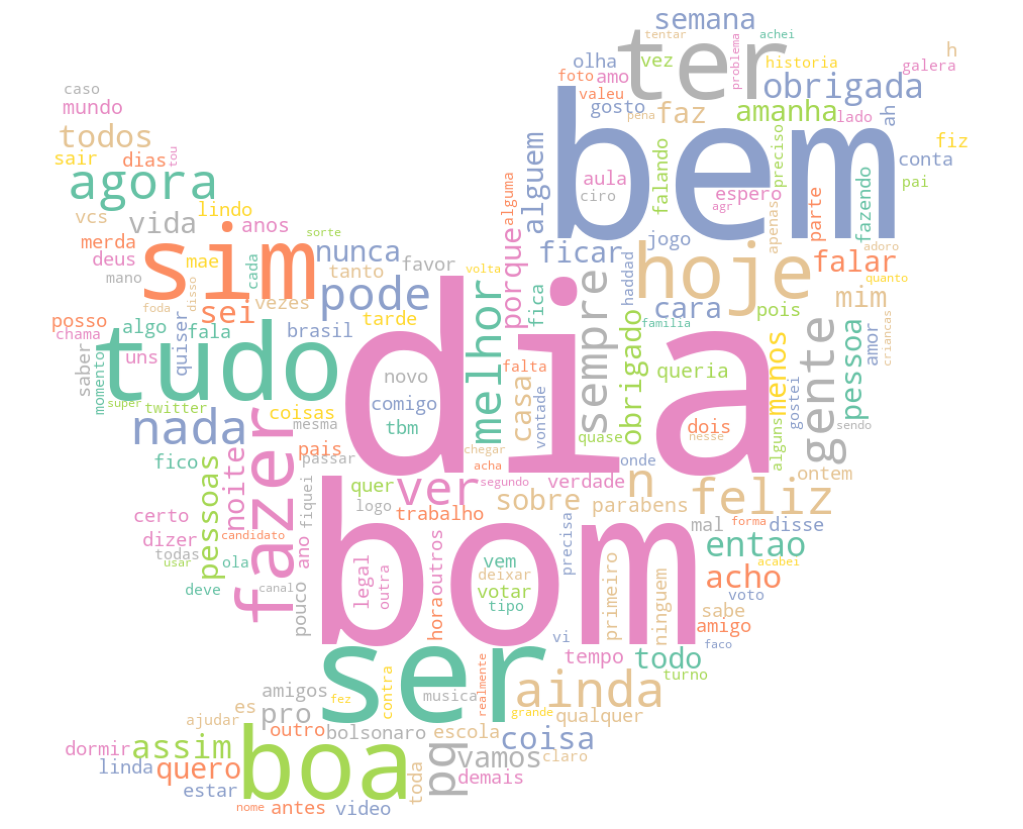

In [20]:
# Wordcloud para sentimentos positivos

filter = (df_train_reduzida["sentiment"] == 1)

# Máscara para usar a imagem de nuvem do Twitter
mask = np.array(Image.open("twitter.png"))

# Criando a wordcloud
wordcloud = (WordCloud(
                        width=3000,
                        height=2000,
                        random_state=1,
                        background_color="white",
                        colormap="Set2",
                        collocations=False,
                        stopwords=stopwords_sem_acentos,
                        mask = mask
                    ).generate_from_frequencies(wc_df(df_train_reduzida, filter=True, filter_type=filter))
     )

# Plotando a wordcloud
plot_cloud(wordcloud)

### Wordcloud para sentimentos NEGATIVOS

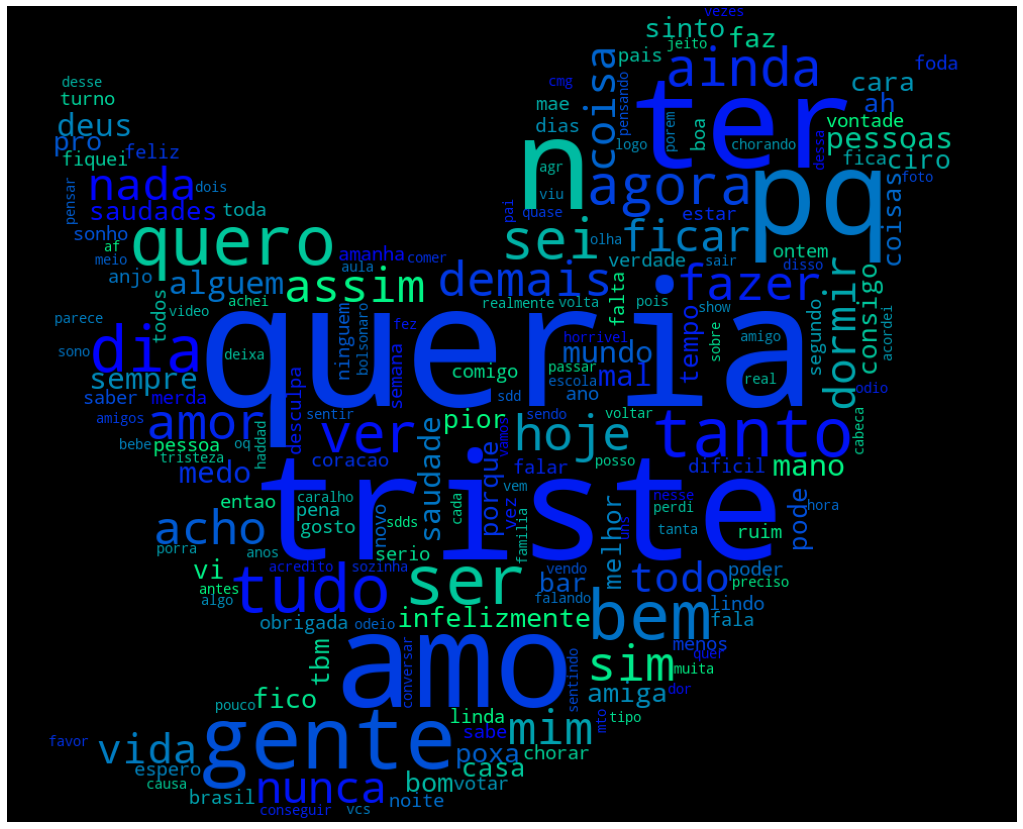

In [21]:
# Wordcloud para sentimentos positivos

filter = (df_train_reduzida["sentiment"] == 0)

# Máscara para usar a imagem de nuvem do Twitter
mask = np.array(Image.open("twitter.png"))

# Criando a wordcloud
wordcloud = (WordCloud(
                        width=3000,
                        height=2000,
                        random_state=1,
                        background_color="black",
                        colormap="winter_r",
                        collocations=False,
                        stopwords=stopwords_sem_acentos,
                        mask = mask
                    ).generate_from_frequencies(wc_df(df_train_reduzida, filter=True, filter_type=filter))
     )

# Plotando a wordcloud
plot_cloud(wordcloud)

### Wordcloud para sentimentos NEUTROS

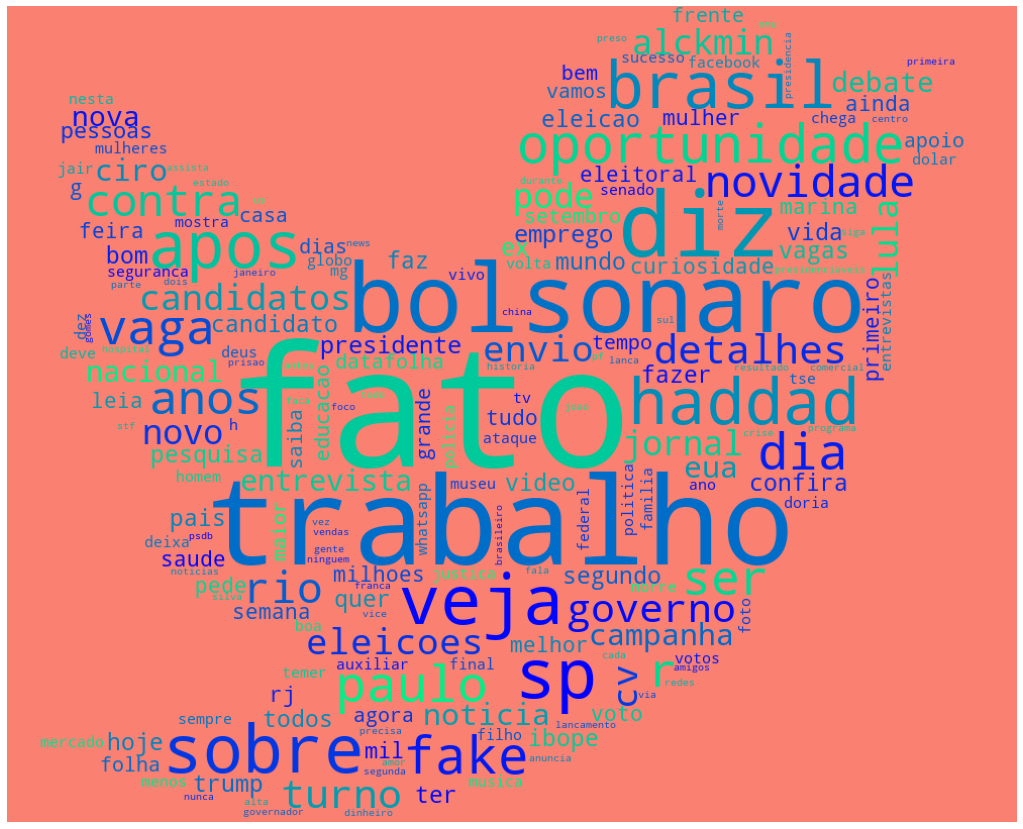

In [22]:
# Wordcloud para sentimentos positivos

filter = (df_train_reduzida["sentiment"] == 2)

# Máscara para usar a imagem de nuvem do Twitter
mask = np.array(Image.open("twitter.png"))

# Criando a wordcloud
wordcloud = (WordCloud(
                        width=3000,
                        height=2000,
                        random_state=1,
                        background_color="salmon",
                        colormap="winter",
                        collocations=False,
                        stopwords=stopwords_sem_acentos,
                        mask = mask
                    ).generate_from_frequencies(wc_df(df_train_reduzida, filter=True, filter_type=filter))
     )

# Plotando a wordcloud
plot_cloud(wordcloud)

### Etapa 3) Modelagem

Iniciaremos o processo de modelagem com um baseline e utilizaremos a transformação de bag of words. Testaremos uma série de modelos a analisaremos as principais métricas (acurrácia, recall, precision, auc).

## Baseline

In [24]:
# Colocar o train_test_splot

def baseline_transform(models, X=df_train_reduzida["text_joined"], y=df_train_reduzida["sentiment"], verbose=False):
    '''
    Função recebe uma lista de modelos, aplica uma transformação de bag of words no dataset e faz uma validação cruzada de 5 folds com cada modelo.
    Além disso ela calcula diversas métricas de avaliação para cada modelo e retorna um dataframe com essas métricas.
    Verbose foi utilizado para imprimir para dar alguma ideia ao usuário do progresso.
    '''
    
    # Dicionário de métricas de avaliação para cada modelo
    models_dict = {}
    # Lista de métricas de avaliação que usaremos
    metrics = ["recall_weighted", "precision_weighted", "f1_weighted", "accuracy", "roc_auc_ovr"]
    
    if verbose:
        print("Iniciando o loop de modelos")
    # Loop para cada modelo
    for model in models:
        if verbose:
            print(f"Fit do modelo {model} iniciado")
        # Criando o pipeline
        pipe = Pipeline(steps=[("vect", CountVectorizer()),
                                (model, models[model])])
        # Fazendo a validação cruzada
        scores = cross_validate(pipe, X, y, cv=5, scoring=metrics, return_train_score=True, n_jobs=-1)

        # Dicionário com as métricas de cada modelo                    
        models_dict[model] = {"recall_test": scores["test_recall_weighted"].mean(),
                                     "recall_train": scores["train_recall_weighted"].mean(),
                                     "precision_test": scores["test_precision_weighted"].mean(),
                                     "precision_train": scores["train_precision_weighted"].mean(),
                                     "f1_test": scores["test_f1_weighted"].mean(),
                                     "f1_train": scores["train_f1_weighted"].mean(),
                                     "accuracy_test": scores["test_accuracy"].mean(),
                                     "accuracy_train": scores["train_accuracy"].mean(),
                                     "roc_auc_test": scores["test_roc_auc_ovr"].mean(),
                                     "roc_auc_train": scores["train_roc_auc_ovr"].mean(),
                                    }
        if verbose:
            print(f"Fit do modelo {model} finalizado")                    
    tabela = pd.DataFrame(models_dict)
    return tabela

In [25]:
# Dicionário de modelos

models = {  "Random Forest": RandomForestClassifier(random_state=43, n_jobs=-1),
            "Gradiente Boost": GradientBoostingClassifier(random_state=43),
            "Regressão Logística": LogisticRegression(random_state=43),
            "XGBoost": XGBClassifier(random_state=43, eval_metric="logloss", use_label_encoder=False, n_jobs=-1)
         }

baseline_table = baseline_transform(models,verbose=True)

Iniciando o loop de modelos
Fit do modelo Random Forest iniciado
Fit do modelo Random Forest finalizado
Fit do modelo Gradiente Boost iniciado
Fit do modelo Gradiente Boost finalizado
Fit do modelo Regressão Logística iniciado
Fit do modelo Regressão Logística finalizado
Fit do modelo XGBoost iniciado
Fit do modelo XGBoost finalizado


In [26]:
baseline_table

Random Forest  Gradiente Boost  Regressão Logística   XGBoost
recall_test           0.753274         0.656926             0.797979  0.727053
recall_train          0.986174         0.662068             0.910005  0.745997
precision_test        0.758579         0.728953             0.798899  0.755918
precision_train       0.986259         0.734249             0.910011  0.775328
f1_test               0.752334         0.660527             0.798204  0.729893
f1_train              0.986185         0.665768             0.909964  0.748810
accuracy_test         0.753274         0.656926             0.797979  0.727053
accuracy_train        0.986174         0.662068             0.910005  0.745997
roc_auc_test          0.901017         0.843999             0.925328  0.890360
roc_auc_train         0.998255         0.848766             0.979500  0.906143

Nosso objetivo é classificar o tweet corretamente, logo, focaremos na métrica de **PRECISION** porque vamos analisar amostrar de tweets, ou seja, nosso objetivo é acertar o maior número de sentimentos corretos nas amostras.

Vale a pena ressaltar que os modelos Random Forest e Regressão Logística aprensentaram overfitting no treino.

O melhor modelo utilizando a métrica **PRECISION** foi o de **Regressão Logísitca** e por isso utilizaremos ele como modelo baseline para testar diferentes transformações de dados. Testaremos as seguintes técnicas:   

- Bag of words
- TF-IDF
- Word2Vec
- Doc2Vec

### Testando transformações

In [38]:
def train_test_word2vec(x,model):
    '''
    Função para criar as amostras de teste e treino do word2vec
    Recebe o dataset e o modelo word2vec
    '''
    X_w2v_sn = [] # lista para somar os vetores
    for phrase in x:
        vecs = []
        for word in phrase:
            if word in model.wv.index_to_key:
                vecs.append(model.wv.get_vector(word))
        if vecs:
            soma_normalizada = np.sum(vecs, axis=0) / np.linalg.norm(np.sum(vecs, axis=0))
            X_w2v_sn.append(soma_normalizada)
        else:
            X_w2v_sn.append(np.zeros(model.vector_size))
    return np.array(X_w2v_sn)

def read_corpus_doc2vec(list_sentences, tokens_only=False):
    '''
    Função para criar os identificadores únicos para os documentos
    '''
    if tokens_only:
        return list_sentences
    else:
        lista = []
        for i, line in enumerate(list_sentences):
            lista.append(doc2vec.TaggedDocument(line, [i]))
        return lista

def train_test_doc2vec(x, model):
    '''
    Função para criar as amostras de teste e treino do doc2vec
    '''
    X_d2v = []
    for phrase in x:
        X_d2v.append(model.infer_vector(phrase))
    return np.array(X_d2v)

# Criando o X e o Y que usaremos nas transformações de bag of words e TF-IDF
X = df_train_reduzida["text_joined"].copy()
y = df_train_reduzida["sentiment"].copy()

# Treino para o bag of words e para o TF-IDF (passamos de treino e teste uma sentença)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# Criando o X e o Y que usaremos nas transformações de word2vec e doc2vec
X_ = df_train_reduzida["text_clean"].copy()
y_ = df_train_reduzida["sentiment"].copy()

# Treino para doc2vec
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_, y_, test_size = 0.3, random_state = 42)

# Fazendo as transformações em cada dataset de treino e teste a cada transformação

##### Bag of words #####
cv = CountVectorizer()
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)
print("Bag of words criado")

###### TF-IDF #####
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfid = tfidf.transform(X_test)
print("TF-IDF criado")

###### Word2Vec skipgram #####
w2v_s = Word2Vec(sentences=X_train_, vector_size=500, min_count=5, workers=-1,sg=1)
X_train_w2v_sn_skip = train_test_word2vec(X_train_,model=w2v_s)
X_test_w2v_sn_skip = train_test_word2vec(X_test_,model=w2v_s)
print("Word2Vec skipgram criado")

##### Word2Vec cbow #####
w2v_c = Word2Vec(sentences=X_train_, vector_size=500, min_count=5, workers=-1,sg=0)
X_train_w2v_sn_cbow = train_test_word2vec(X_train_,model=w2v_c)
X_test_w2v_sn_cbow = train_test_word2vec(X_test_,model=w2v_c)
print("Word2Vec cbow criado")

##### Doc2vec #####
train_corpus = read_corpus_doc2vec(X_train_)
test_corpus = read_corpus_doc2vec(X_test_, tokens_only=True)
d2v = doc2vec.Doc2Vec(vector_size=500, min_count=2, epochs=20)
d2v.build_vocab(train_corpus)
d2v.train(train_corpus, total_examples=d2v.corpus_count, epochs=d2v.epochs)
X_train_d2v = train_test_doc2vec(X_train_,model=d2v)
X_test_d2v = train_test_doc2vec(X_test_,model=d2v)
print("Doc2vec criado")

Bag of words criado
TF-IDF criado
Word2Vec skipgram criado
Word2Vec cbow criado
Doc2vec criado


In [56]:
def try_transformers(transformers_dict, model):
    '''
    Função para testar todas as transformações no dataset usando a regressão logística como modelo padrão.
    A função recebe um dicionário de datasets de treino e teste associados a cada transformação e retorna uma tabela de métricas de avaliação de cada transformação
    '''
    
    # Dicionário de métricas para cada transformador
    transformers_metrics = {}
    
    # Lista de métricas a serem avaliadas
    metrics = ["recall_weighted", "precision_weighted", "f1_weighted", "accuracy", "roc_auc_ovr"]

    # Loop para testar todas as transformações
    for transformer,train_test_sets in transformers_dict.items():
        print(transformer.upper())
        print(f"Treinando {transformer}")
        
        # Fazendo a validação cruzada (usando somente a base de treino)
        scores = cross_validate(model, train_test_sets["X_train"],
                                train_test_sets["y_train"], cv=5,
                                scoring=metrics, n_jobs=-1)
        print(f"Treinamento com {transformer} finalizado")


        print(f"Testando {transformer}")
              
        # Fitando o modelo agora com toda a base de treino
        model.fit(train_test_sets["X_train"], train_test_sets["y_train"])
        
        # Predizendo com a base de teste 
        y_pred_test = model.predict(train_test_sets["X_test"])
        
        # Predizendo a probabilidade de cada label
        y_pred_test_prob = model.predict_proba(train_test_sets["X_test"])

        # Calculando as métricas de avaliação do teste
        accuracy_test = accuracy_score(train_test_sets["y_test"], y_pred_test)
        precision_test = precision_score(train_test_sets["y_test"], y_pred_test, average="weighted")
        recall_test = recall_score(train_test_sets["y_test"], y_pred_test, average="weighted")
        f1_test = f1_score(train_test_sets["y_test"], y_pred_test, average="weighted")
        auc_test = roc_auc_score(train_test_sets["y_test"], y_pred_test_prob,multi_class="ovr")
                
        # Dicionário com as métricas de cada modelo                    
        transformers_metrics[transformer] = {"recall_test": recall_test,
                                     "recall_train": scores["test_recall_weighted"].mean(),
                                     "precision_test": precision_test,
                                     "precision_train": scores["test_precision_weighted"].mean(),
                                     "f1_test": f1_test,
                                     "f1_train": scores["test_f1_weighted"].mean(),
                                     "accuracy_test": accuracy_test,
                                     "accuracy_train": scores["test_accuracy"].mean(),
                                     "roc_auc_test": auc_test,
                                     "roc_auc_train": scores["test_roc_auc_ovr"].mean(),
                                    }
        print(f"Teste com {transformer} finalizado")

        print('''        
                 ###############################################
                 ############ Classification Report ############
                 ###############################################
               ''' )   
        print(classification_report(train_test_sets["y_test"] ,y_pred_test))
    
        print(50*"*", '\n')
        
    table = pd.DataFrame(transformers_metrics)
    return table

# Dicionário de transformadores com suas respectivas bases de treino e testes com as transformações aplicadas

transformers_train_test_sets = {"bag of words":{"X_train":X_train_cv,
                                                "X_test":X_test_cv,
                                                "y_train":y_train,
                                                "y_test":y_test},

                                        "TF-IDF":{"X_train":X_train_tfidf,
                                                "X_test":X_test_tfid,
                                                "y_train":y_train,
                                                "y_test":y_test},

                            "Word2Vec skipgram":{"X_train":X_train_w2v_sn_skip,
                                                "X_test":X_test_w2v_sn_skip,
                                                "y_train":y_train_,
                                                "y_test":y_test_},

                                "Word2Vec cbow":{"X_train":X_train_w2v_sn_cbow,
                                                "X_test":X_test_w2v_sn_cbow,
                                                "y_train":y_train_,
                                                "y_test":y_test_},
                                                
                                    "Doc2vec":{"X_train":X_train_d2v,
                                                "X_test":X_test_d2v,
                                                "y_train":y_train_,"y_test":y_test_}}

Nota-se que em todos os modelos, os sentimentos neutros (2) possuem a melhor precision.

In [60]:
table = try_transformers(transformers_train_test_sets, LogisticRegression(random_state=43))

BAG OF WORDS
Treinando bag of words
Treinamento com bag of words finalizado
Testando bag of words


c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Teste com bag of words finalizado
        
                 ###############################################
                 ############ Classification Report ############
                 ###############################################
               
              precision    recall  f1-score   support

           0       0.72      0.76      0.74      9559
           1       0.71      0.69      0.70      9555
           2       0.95      0.93      0.94      9386

    accuracy                           0.79     28500
   macro avg       0.79      0.79      0.79     28500
weighted avg       0.79      0.79      0.79     28500

************************************************** 

TF-IDF
Treinando TF-IDF
Treinamento com TF-IDF finalizado
Testando TF-IDF


c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Teste com TF-IDF finalizado
        
                 ###############################################
                 ############ Classification Report ############
                 ###############################################
               
              precision    recall  f1-score   support

           0       0.76      0.72      0.74      9559
           1       0.71      0.73      0.72      9555
           2       0.92      0.95      0.93      9386

    accuracy                           0.80     28500
   macro avg       0.80      0.80      0.80     28500
weighted avg       0.80      0.80      0.80     28500

************************************************** 

WORD2VEC SKIPGRAM
Treinando Word2Vec skipgram
Treinamento com Word2Vec skipgram finalizado
Testando Word2Vec skipgram
Teste com Word2Vec skipgram finalizado
        
                 ###############################################
                 ############ Classification Report ############
                 #####

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Teste com Doc2vec finalizado
        
                 ###############################################
                 ############ Classification Report ############
                 ###############################################
               
              precision    recall  f1-score   support

           0       0.60      0.58      0.59      9559
           1       0.57      0.57      0.57      9555
           2       0.69      0.72      0.70      9386

    accuracy                           0.62     28500
   macro avg       0.62      0.62      0.62     28500
weighted avg       0.62      0.62      0.62     28500

************************************************** 



In [61]:
table

bag of words    TF-IDF  Word2Vec skipgram  Word2Vec cbow  \
recall_test          0.792702  0.797333           0.645228       0.645228   
recall_train         0.792902  0.798090           0.638466       0.638466   
precision_test       0.793723  0.796824           0.643973       0.643973   
precision_train      0.794387  0.798570           0.637227       0.637227   
f1_test              0.793016  0.796736           0.644320       0.644320   
f1_train             0.793415  0.797780           0.637589       0.637589   
accuracy_test        0.792702  0.797333           0.645228       0.645228   
accuracy_train       0.792902  0.798090           0.638466       0.638466   
roc_auc_test         0.921312  0.925207           0.824853       0.824853   
roc_auc_train        0.922394  0.926073           0.821890       0.821890   

                  Doc2vec  
recall_test      0.619930  
recall_train     0.611789  
precision_test   0.618669  
precision_train  0.610282  
f1_test          0.619128  
f1_train         0.610806  
accuracy_test    0.619930  
accuracy_train   0.611789  
roc_auc_test     0.801192  
roc_auc_train    0.794310

Através do Classification Report, podemos constatar que o tipo de transformação que mais traz resultado é o **TF-IDF**, visto que ele possui a precision da classe 0 (sentimentos negativos) maior.   

Os sentimentos negativos podem trazer mais insights sobre pontos de melhoria, desta forma focamos na transformação que tem a maior precision para a classe 0.

### Tunando os modelos

In [62]:
transformers_train_test_sets["TF-IDF"]["X_train"]

<66500x47487 sparse matrix of type '<class 'numpy.float64'>'
	with 470859 stored elements in Compressed Sparse Row format>

In [63]:
transformers_train_test_sets["TF-IDF"]["y_train"]

56308    1
60387    1
4872     0
28954    0
56766    1
        ..
6265     2
54886    0
76820    0
860      0
15795    1
Name: sentiment, Length: 66500, dtype: int64

Para otimização, utilizaremos a biblioteca **optuna** com os seguintes hiperparâmetros de tunning:

- penalty: tipo de penalidade que usaremos, podendo ser nenhuma, l1(lasso), l2(ridge) e elasticnet;
- tol: tolerância do critério de parada, ou seja, a partir de quanto o modelo irá parar se não houver melhora;
- C: inverso da força da regularização. Quanto maior, menor será a força da regularização;
- solver: tipo de solver utilizado. Lendo a documentação vemos que os métodos 'saga' e 'sag' são melhores para datasets grandes. Considerando o tempo que o optuna está levando para fazer cada trial, vamos considerar nosso dataset grande e usaremos somente o método saga para conseguir utilizar todas as penalizações;
- max_iter: número máximo de interações para o algoritmo convergir ao máximo likelyhood;
- warm_start: com esse parâmetro o algoritmo usa as soluções anteriores para realizar as próximas soluções;
- l1_ratio: parâmetro para a penalização elasticnet. Se esse parâmetro for 0 ou 1 é equivalente a usar o l2 ou o l1, respectivamente.

In [66]:
# Definindo uma função objetivo

def objective(trial):
    # Definindo o dicionário com o grid de parâmetros que testaremos
    params = dict(
        penalty = trial.suggest_categorical("penalty",["none", "l1", "l2", "elasticnet"]),
        tol = trial.suggest_float("tol", 1e-4, 1e-2, log=True),
        C = trial.suggest_float("C", 1, 3.5),
        max_iter = trial.suggest_float("max_iter", 100, 500),
        warm_start = trial.suggest_categorical("warm_start", [True, False]),
        l1_ratio = trial.suggest_float("l1_ratio", 0, 1),
    )
    
    # Instanciado o modelo
    model = LogisticRegression(**params, random_state=43, n_jobs=-1, solver="saga", multi_class="multinomial")
    
    # O que queremos maximizar é a métrica precision e para isso faremos um cross validation de 5 folds, como teremos 5 precision de retorno (para cada fold), pegaremos a média deles

    return cross_validate(model,
                        transformers_train_test_sets["TF-IDF"]["X_train"], # dataset de treino com a transformação aplicada
                        transformers_train_test_sets["TF-IDF"]["y_train"], # dataset de treino com a transformação aplicada
                        scoring=["precision_weighted"],
                        cv = 5,
                        n_jobs=-1)["test_precision_weighted"].mean()

study_lg = optuna.create_study(direction="maximize", study_name ="Logistic Regression Study")
study_lg.optimize(objective, n_trials=100)
reglog_params = study_lg.best_params

[I 2022-05-24 18:16:34,865] A new study created in memory with name: Logistic Regression Study
[I 2022-05-24 18:16:58,655] Trial 0 finished with value: 0.7602775793698446 and parameters: {'penalty': 'none', 'tol': 0.002607226112326655, 'C': 1.521558130223529, 'max_iter': 105.72374711149273, 'warm_start': True, 'l1_ratio': 0.20224626254760447}. Best is trial 0 with value: 0.7602775793698446.
[I 2022-05-24 18:54:10,005] Trial 1 finished with value: 0.7967334885375589 and parameters: {'penalty': 'elasticnet', 'tol': 0.00014426842878309765, 'C': 2.517015255688793, 'max_iter': 309.72441595138434, 'warm_start': True, 'l1_ratio': 0.02255541544400952}. Best is trial 1 with value: 0.7967334885375589.
[I 2022-05-24 19:06:17,658] Trial 2 finished with value: 0.7891843512984243 and parameters: {'penalty': 'l1', 'tol': 0.00034155761644313014, 'C': 2.7968617010559966, 'max_iter': 155.43352140308056, 'warm_start': True, 'l1_ratio': 0.6661691834372965}. Best is trial 1 with value: 0.7967334885375589.


In [67]:
reglog_params

{'penalty': 'l2',
 'tol': 0.0033663145073861314,
 'C': 1.0015809375827887,
 'max_iter': 264.7901122978059,
 'warm_start': False,
 'l1_ratio': 0.786937068276871}

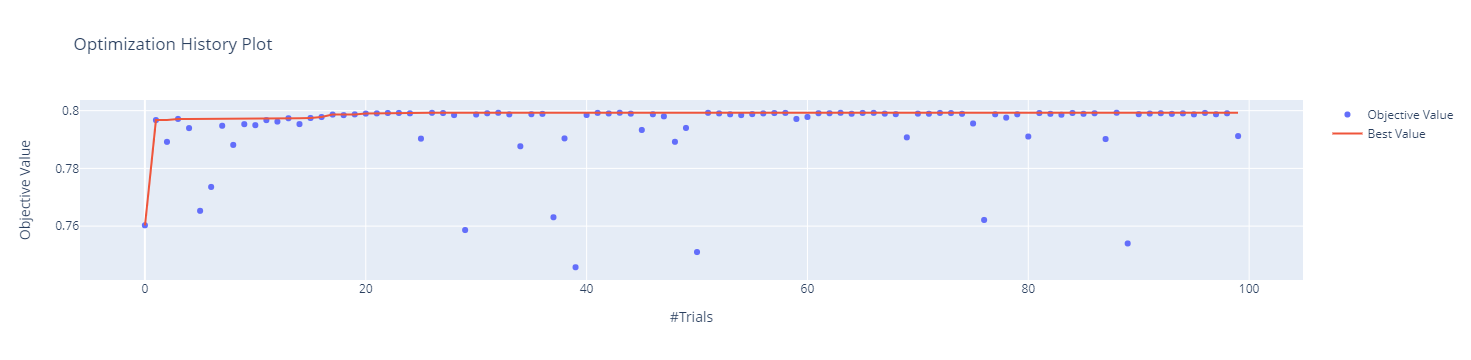

In [68]:
plot_optimization_history(study_lg)

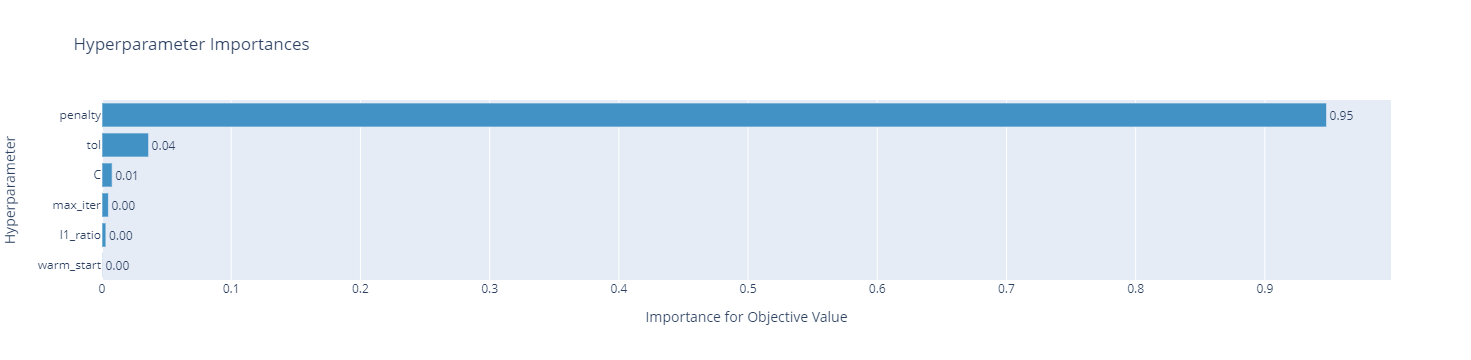

In [69]:
plot_param_importances(study_lg)

O hiperparâmetro de maior importância foi a penalidade (penalty), com 95% de importância.

Agora vamos treinar o modelo com os melhores hiperparâmetros e com todos os dados de treino.

In [70]:
reglog_paramns_final = {"penalty": "l2",
 "tol": 0.0033663145073861314,
 "C": 1.0015809375827887,
 "max_iter": 264.7901122978059,
 "warm_start": False,}

model = LogisticRegression(**reglog_paramns_final, random_state=43, n_jobs=-1, solver="saga", multi_class="multinomial")
model.fit(transformers_train_test_sets["TF-IDF"]["X_train"], transformers_train_test_sets["TF-IDF"]["y_train"])
y_pred = model.predict(transformers_train_test_sets["TF-IDF"]["X_test"])
y_pred_proba = model.predict_proba(transformers_train_test_sets["TF-IDF"]["X_test"])

print(classification_report(transformers_train_test_sets["TF-IDF"]["y_test"],y_pred))

              precision    recall  f1-score   support

           0       0.76      0.72      0.74      9559
           1       0.71      0.73      0.72      9555
           2       0.92      0.95      0.93      9386

    accuracy                           0.80     28500
   macro avg       0.80      0.80      0.80     28500
weighted avg       0.80      0.80      0.80     28500



Como resultado final, temos os seguintes números de **precision**:   

. 0 (negativo): 76%   
. 1 (positivo): 71%   
. 2 (neutro): 92%

Abaixo, vamos gerar o arquivo de predição com a base de submissão, treinando o modelo com a base de treino e gerando um .csv de predição.

In [71]:
tfid= TfidfVectorizer()
X_train_ful = tfid.fit_transform(df_train_reduzida["text_joined"]) # treinamento com toda a base
X_test_full = tfid.transform(df_subm_reduzida["text_joined"]) # transformação na base de produção/subsmissão

# Fitando e gerando as predições
model = LogisticRegression(**reglog_paramns_final, random_state=43, n_jobs=-1, solver="saga", multi_class="multinomial")
model.fit(X_train_ful, df_train_reduzida["sentiment"])
predictions = model.predict(X_test_full)

#Gerando o arquivo cvs com as predições no formato especificado
pd.DataFrame(index=df_subm["id"],data={"sentiment_predict":predictions}).to_csv("Pedro_Bastos_SantAna_735_projeto_2_submissao.csv")

### Conclusão

Nosso modelo ficou muito bom para predizer os sentimentos neutros (92% de precisão) e razoável para predizer os sentimentos negativos (76% de precisão) e positivos (71% de precisão).